In [1]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pickle
import pandas as pd
%matplotlib inline  

In [2]:
raw = np.load("190322_RF_Classifier_zone_1_3_200trees_balancedMask_525000smallZones_99percentRandomZones_46features____Prediction_zone2_proba.npy")
step1 = np.load("step1.5_bilateral_denoise.npy")
step2 = np.load("step1_NoiseRemoval.npy")
step3 = np.load("step2_Conic.npy")
step4 = np.load("step3_zones6x6_25Percent.npy")
step5 = np.load("step4_removedIslands_3steps.npy")

FileNotFoundError: [Errno 2] No such file or directory: '190322_RF_Classifier_zone_1_3_200trees_balancedMask_525000smallZones_99percentRandomZones_46features____Prediction_zone2_proba.npy'

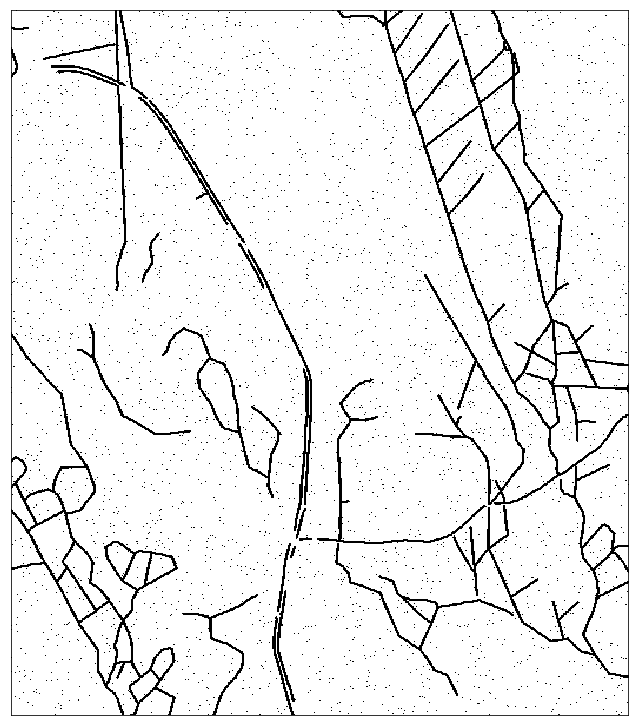

In [75]:
plt.figure(num=None, figsize=(18,10), facecolor='w', edgecolor='k')
ax = [plt.subplot(1,1,i+1) for i in range(1)]
for a in ax:
    a.set_xticklabels([])
    a.set_yticklabels([])
    a.tick_params(bottom=False, left=False)

plt.subplots_adjust(wspace=0.025,hspace=0.05, top=0.99, bottom=0.01)

x,y = (25,175)

#ax[0].text(x,y,"A", fontsize=40, fontdict={"color":"white"}, path_effects=[path_effects.withStroke(linewidth=2, foreground='black')])
#ax[0].imshow(np.load("../cropped_data/balandedMask1.npy") * -1, cmap='gray')

#ax[1].text(x,y,"B", fontsize=40, fontdict={"color":"white"}, path_effects=[path_effects.withStroke(linewidth=2, foreground='black')])
ax[0].imshow(np.load("../cropped_data/balandedMask3.npy") * -1, cmap='gray')
"""
ax[2].text(x,y,"C", fontsize=40, fontdict={"color":"white"})
ax[2].imshow(step2)

ax[3].text(x,y,"D", fontsize=40, fontdict={"color":"white"})
ax[3].imshow(step3)

ax[4].text(x,y,"E", fontsize=40, fontdict={"color":"white"})
ax[4].imshow(step4)

ax[5].text(x,y,"F", fontsize=40, fontdict={"color":"white"})
ax[5].imshow(step5)
"""

plt.savefig("publ_balanced_masks_B.jpg", format="jpg", dpi=600, bbox_inches="tight")

In [2]:
# General arr lib
import numpy as np

# Compile py code
from numba import jit
from numba import prange

# Multithreading
import dask.array as da
import dask as dk
dk.config.set(scheduler='processes')

from dask_image.ndfilters import generic_filter as d_gf

from collections import deque

from skimage.filters import gabor
from skimage.restoration import  denoise_bilateral

import datetime

import numpy as np
from numpy import random, nanmax, argmax, unravel_index
from scipy.spatial.distance import pdist, squareform
from scipy.ndimage.filters import generic_filter as gf
import scipy.stats.mstats as ms
from scipy.stats import skew
import scipy.ndimage.morphology as morph
from scipy import ndimage
from PIL import Image
import scipy
import matplotlib.pyplot as plt
import re
import os
import pandas as pd
import random
import math
from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral, denoise_wavelet, estimate_sigma)
from skimage import data, img_as_float
from skimage.filters import gabor
from skimage.util import random_noise
from collections import deque
from sklearn.ensemble import RandomForestClassifier
from joblib import dump, load
from sklearn.metrics import cohen_kappa_score, accuracy_score, recall_score, confusion_matrix, precision_score
from numba import jit
from numba import prange

@jit
def create_conic_mask(radius, direction):
    """
    Internally used to create conic mask for a direction and with a certain radius.
    """
    kernel = np.zeros((2*radius+1, 2*radius+1))
    y, x = np.ogrid[-radius:radius+1, -radius:radius+1]

    if direction == 0:  # topright
        mask = (x > y) & (x < abs(y)) & (x**2 + y**2 <= radius**2) & (x > 0)
    elif direction == 1:  # righttop
        mask = (x > abs(y)) & (x**2 + y**2 <= radius**2) & (y < 0)
    elif direction == 2:  # rightbottom
        mask = (x > abs(y)) & (x**2 + y**2 <= radius**2) & (y > 0)
    elif direction == 3:  # bottomright
        mask = (abs(x) < y) & (x**2 + y**2 <= radius**2) & (x > 0)
    elif direction == 4:  # bottomleft
        mask = (abs(x) < y) & (x**2 + y**2 <= radius**2) & (x < 0)
    elif direction == 5:  # leftbottom
        mask = (abs(x) > abs(y)) & (x < abs(y)) & (
            x**2 + y**2 <= radius**2) & (y > 0)
    elif direction == 6:  # lefttop
        mask = (abs(x) > abs(y)) & (x < abs(y)) & (
            x**2 + y**2 <= radius**2) & (y < 0)
    elif direction == 7:  # topleft
        mask = (x > y) & (x < abs(y)) & (x**2 + y**2 <= radius**2) & (x < 0)
    kernel[mask] = 1
    return kernel

@jit
def create_circular_mask(radius):
    """
    Creates a circular mask.
    """
    kernel = np.zeros((2*radius+1, 2*radius+1))
    y, x = np.ogrid[-radius:radius+1, -radius:radius+1]
    mask = x**2 + y**2 <= radius**2
    mask[radius][radius] = 0
    kernel[mask] = 1
    return kernel

@jit(nopython=True)
def raster_to_zones(arr, zoneSize, threshold):
    """
    Converts binary pixel labels to zones with a specified zone size and threshold.
    """
    new_arr = arr.copy()
    for i in range(0, len(arr), zoneSize):
        for j in range(0, len(arr[i]), zoneSize):
            numberOfClassified = 0
            if i < len(arr) - zoneSize and j < len(arr[i]) - zoneSize:
                for k in range(zoneSize):
                    for l in range(zoneSize):
                        if arr[i + k][j + l] == 1:
                            numberOfClassified += 1
                if numberOfClassified > (zoneSize**2)/threshold:
                    for k in range(zoneSize):
                        for l in range(zoneSize):
                            new_arr[i + k][j + l] = 1
                else:
                    for k in range(zoneSize):
                        for l in range(zoneSize):
                            new_arr[i + k][j + l] = 0
    return new_arr


@jit(nopython=True)
def proba_to_zones(arr, zoneSize, threshold):
    """
    Converts continuous pixel probability values to zones with a specified zone size and threshold.
    """
    new_arr = np.zeros(arr.shape)
    for i in range(0, len(arr), zoneSize):
        for j in range(0, len(arr[i]), zoneSize):
            totalProba = 0
            if i < len(arr) - zoneSize and j < len(arr[i]) - zoneSize:
                for k in range(zoneSize):
                    for l in range(zoneSize):
                        totalProba += arr[i+k][j+l]
                if totalProba / zoneSize**2 > threshold:
                    for k in range(zoneSize):
                        for l in range(zoneSize):
                            new_arr[i + k][j + l] = 1
                else:
                    for k in range(zoneSize):
                        for l in range(zoneSize):
                            new_arr[i + k][j + l] = 0
    return new_arr


@jit(nopython=True)
def _custom_remove_noise(arr, max_arr, new_arr, threshold, selfThreshold):
    """
    Internal noise removal function of probability prediction.
    """
    for i in range(len(arr)):
        for j in range(len(arr[i])):
            if max_arr[i][j] < threshold:
                if arr[i][j] > selfThreshold:
                    new_arr[i][j] *= 0.5
                else:
                    new_arr[i][j] *= 0.25
    return new_arr


@jit
def custom_remove_noise(arr, radius, threshold, selfThreshold):
    """
    Removes noise from a probability prediction.
    """
    max_arr = d_gf(da.from_array(arr, chunks=(800, 800)), np.nanmax,
                   footprint=create_circular_mask(radius)).compute(scheduler='processes')
    return _custom_remove_noise(arr, max_arr, np.copy(arr), threshold, selfThreshold)

def find_max_distance(A):
    """
    Returns the maximum distance from  2x points.
    Each point is represented by an x,y coordinate.
    """
    return nanmax(squareform(pdist(A)))


def remove_clusters(arr, zoneSize, lowerIslandThreshold, upperIslandThreshold, ratioThreshold):
    """
    Removes noise in the form of small clusters or clusters of a non ditch shape from a binarized prediction.
    """
    new_arr = arr.copy()
    examinedPoints = set()
    for i in range(len(arr)):
        for j in range(len(arr[i])):
            if arr[i][j] == 1 and (i, j) not in examinedPoints:
                cluster = _get_cluster_array(arr, (i, j), zoneSize)
                cluster_size = len(cluster)
                if cluster_size < upperIslandThreshold:
                    cluster_distance = find_max_distance(cluster)
                for k in range(cluster_size):
                    examinedPoints.add(cluster[k])
                    if cluster_size < upperIslandThreshold:
                        if cluster_size < lowerIslandThreshold:
                            new_arr[cluster[k][0]][cluster[k][1]] = 0
                        elif cluster_size / cluster_distance > ratioThreshold:
                            new_arr[cluster[k][0]][cluster[k][1]] = 0
    return new_arr      
        
@jit
def _get_cluster_array(arr, index, zoneSize):
    """
    Internal function to receive an array of all the pixels of a binary cluster.
    """
    arrayOfPoints = []
    iMax = len(arr) - 1
    jMax = len(arr[0]) - 1
    i = index[0]
    j = index[1]
    FIFOQueue = deque([(i, j)])
    examinedElements = set()
    examinedElements.add((i, j))
    while (len(FIFOQueue) > 0):
        currentIndex = FIFOQueue.popleft()
        i = currentIndex[0]
        j = currentIndex[1]
        if i >= 0 and i < iMax and j >= 0 and j < jMax and arr[i][j] == 1:
            arrayOfPoints.append((i, j))
            # add horizontally and vertically
            if (i+1, j) not in examinedElements:
                FIFOQueue.append((i+1, j))
                examinedElements.add((i+1, j))
            if (i-1, j) not in examinedElements:
                FIFOQueue.append((i-1, j))
                examinedElements.add((i-1, j))
            if (i, j+1) not in examinedElements:
                FIFOQueue.append((i, j+1))
                examinedElements.add((i, j+1))
            if (i, j-1) not in examinedElements:
                FIFOQueue.append((i, j-1))
                examinedElements.add((i, j-1))
            # add diagonally
            if (i+1, j+1) not in examinedElements:
                FIFOQueue.append((i+1, j+1))
                examinedElements.add((i+1, j+1))
            if (i-1, j+1) not in examinedElements:
                FIFOQueue.append((i-1, j+1))
                examinedElements.add((i-1, j+1))
            if (i+1, j-1) not in examinedElements:
                FIFOQueue.append((i+1, j-1))
                examinedElements.add((i+1, j-1))
            if (i-1, j-1) not in examinedElements:
                FIFOQueue.append((i-1, j-1))
                examinedElements.add((i-1, j-1))

            # Add one zone away
            # add horizontally and vertically
            if (i+1 + zoneSize, j) not in examinedElements:
                FIFOQueue.append((i+1 + zoneSize, j))
                examinedElements.add((i+1 + zoneSize, j))
            if (i-1 - zoneSize, j) not in examinedElements:
                FIFOQueue.append((i-1 - zoneSize, j))
                examinedElements.add((i-1 - zoneSize, j))
            if (i, j+1 + zoneSize) not in examinedElements:
                FIFOQueue.append((i, j+1 + zoneSize))
                examinedElements.add((i, j+1 + zoneSize))
            if (i, j-1 - zoneSize) not in examinedElements:
                FIFOQueue.append((i, j-1 - zoneSize))
                examinedElements.add((i, j-1 - zoneSize))
            # add diagonally
            if (i+1 + zoneSize, j+1 + zoneSize) not in examinedElements:
                FIFOQueue.append((i+1 + zoneSize, j+1 + zoneSize))
                examinedElements.add((i+1 + zoneSize, j+1 + zoneSize))
            if (i-1 - zoneSize, j+1 + zoneSize) not in examinedElements:
                FIFOQueue.append((i-1 - zoneSize, j+1 + zoneSize))
                examinedElements.add((i-1 - zoneSize, j+1 + zoneSize))
            if (i+1 + zoneSize, j-1 - zoneSize) not in examinedElements:
                FIFOQueue.append((i+1 + zoneSize, j-1 - zoneSize))
                examinedElements.add((i+1 + zoneSize, j-1 - zoneSize))
            if (i-1 - zoneSize, j-1 - zoneSize) not in examinedElements:
                FIFOQueue.append((i-1 - zoneSize, j-1 - zoneSize))
                examinedElements.add((i-1 - zoneSize, j-1 - zoneSize))
    return arrayOfPoints


@jit(nopython=True)
def _proba_mean_from_masks(arr, row, col, masks):
    """
    Internal function to get the mean value of a set of conic masks from a pixel.
    """
    halfMask = len(masks[0]) // 2    
    arrLenRow = len(arr)
    arrLenCol = len(arr[row])
    values = np.zeros(8)
    elementAmounts = np.zeros(8)
    for i in range(-halfMask , halfMask):
        for j in range(-halfMask , halfMask):
            if arrLenCol > col + j + 1 and col + j + 1 >= 0 and arrLenRow > row + i + 1 and row + i + 1 >= 0:
                if masks[0][i + halfMask][j + halfMask] == 1:
                    values[0] += arr[row + i][col + j]
                    elementAmounts[0] += 1
                elif masks[1][i + halfMask][j + halfMask] == 1:
                    values[1] += arr[row + i][col + j]
                    elementAmounts[1] += 1
                elif masks[2][i + halfMask][j + halfMask] == 1:
                    values[2] += arr[row + i][col + j]
                    elementAmounts[2] += 1
                elif masks[3][i + halfMask][j + halfMask] == 1:
                    values[3] += arr[row + i][col + j]
                    elementAmounts[3] += 1
                elif masks[4][i + halfMask][j + halfMask] == 1:
                    values[4] += arr[row + i][col + j]
                    elementAmounts[4] += 1
                elif masks[5][i + halfMask][j + halfMask] == 1:
                    values[5] += arr[row + i][col + j]
                    elementAmounts[5] += 1
                elif masks[6][i + halfMask][j + halfMask] == 1:
                    values[6] += arr[row + i][col + j]
                    elementAmounts[6] += 1
                elif masks[7][i + halfMask][j + halfMask] == 1:
                    values[7] += arr[row + i][col + j]
                    elementAmounts[7] += 1
    for i in range(len(values)):
        values[i] = values[i] / elementAmounts[i] if elementAmounts[i] != 0 else 0
    return values


@jit(nopython=True)
def _conic_proba_post_processing(arr, maxArr, masks, threshold):
    """
    Internal function to fill the gaps of a continuous probability prediction array.
    """
    new_arr = arr.copy()
    amountOfUpdated = 0
    examinedPoints = 0
    for i in range(len(arr)):
        for j in range(len(arr[i])):
            if arr[i][j] < 0.5 and maxArr[i][j] > 0.6:
                examinedPoints += 1
                trueProba = _proba_mean_from_masks(arr, i, j, masks)
                
                updatePixel = 0
                if trueProba[0] > threshold and trueProba[4] > threshold:
                    updatePixel = trueProba[0] if trueProba[0] > trueProba[4] else trueProba[4]
                if trueProba[1] > threshold and trueProba[5] > threshold:
                    updatePixelAgain = trueProba[1] if trueProba[1] > trueProba[5] else trueProba[5]
                    if updatePixelAgain > updatePixel:
                        updatePixel = updatePixelAgain
                if trueProba[2] > threshold and trueProba[6] > threshold:
                    updatePixelAgain = trueProba[2] if trueProba[6] > trueProba[2] else trueProba[6]
                    if updatePixelAgain > updatePixel:
                        updatePixel = updatePixelAgain
                if trueProba[3] > threshold and trueProba[7] > threshold:
                    updatePixelAgain = trueProba[3] if trueProba[3] > trueProba[7] else trueProba[7]
                    if updatePixelAgain > updatePixel:
                        updatePixel = updatePixelAgain
                if updatePixel != 0:
                    amountOfUpdated += 1
                    if updatePixel < 0.5:
                        updatePixel *= 1.4
                    elif updatePixel < 0.55:
                        updatePixel *= 1.35
                    elif updatePixel < 0.6:
                        updatePixel *= 1.3
                    elif updatePixel < 0.65:
                        updatePixel *= 1.25
                    elif updatePixel < 0.7:
                        updatePixel *= 1.2
                    elif updatePixel < 0.75:
                        updatePixel *= 1.15
                    elif updatePixel < 0.85:
                        updatePixel *= 1.1
                    elif updatePixel < 0.9:
                        updatePixel *= 1.05
                    new_arr[i][j] = updatePixel
    return new_arr

@jit
def conic_proba_post_processing(arr, maskRadius, threshold):
    """
    Attempts to fill the gaps of a continuous probability prediction array.
    """
    masks = []
    maxArr = d_gf(da.from_array(arr,chunks = (800,800)), np.nanmax, footprint=create_circular_mask(5))
    for i in range(0, 8):
        masks.append(create_conic_mask(maskRadius, i))

    return _conic_proba_post_processing(np.array(arr), np.array(maxArr), np.array(masks),threshold)
    
def _denoise_bilateral(arr):
    """
    Internal first noise removal step of a continuous probability prediction.
    """
    return denoise_bilateral(arr, sigma_spatial=15, multichannel=False)

def proba_noise_reduction(arr):
    """
    Removes noise from a continuous probability prediction.
    """
    d = da.from_array(arr, chunks=(800,800))
    return custom_remove_noise(d.map_overlap(_denoise_bilateral, depth=15).compute(), 10, 0.7, 0.4)
    

def proba_post_process(arr, zoneSize, probaThreshold):
    """
    Processes a continuous probability prediction in various ways to receive a final binarized ditch prediction.
    """
    deNoise = proba_noise_reduction(arr)
    gapFilled = conic_proba_post_processing(conic_proba_post_processing(deNoise, 8, 0.35), 5, 0.3)
    zonesArr = proba_to_zones(gapFilled, zoneSize, 0.4)
    noIslands = remove_clusters(zonesArr, zoneSize*2, 1500, 10000, 30)
    noIslands = remove_clusters(noIslands, zoneSize, 1000, 5000, 20)
    noIslands = remove_clusters(noIslands, 0, 500, 3000, 18)
    noIslands = remove_clusters(noIslands, 0, 500, 1200, 14)
    return noIslands


In [2]:
predictions = np.load("../../Slutexperiment/predictions.npy")

In [23]:
prediction = predictions[6][0].reshape(2997, 2620)

In [26]:
np.save("raw_pred.npy", prediction)

In [27]:
bilateral = _denoise_bilateral(prediction)

In [28]:
np.save("bilateral.npy", bilateral)

In [35]:
custom_noise = custom_remove_noise(bilateral, 10, 0.7, 0.4)

In [36]:
np.save("custom_noise.npy", custom_noise)

In [41]:
gaps_filled = conic_proba_post_processing(conic_proba_post_processing(custom_noise, 8, 0.35), 5, 0.3)

In [42]:
np.save("gaps_filled.npy", gaps_filled)

In [46]:
zones_arr = proba_to_zones(gaps_filled, 6, 0.4)

In [47]:
np.save("zones_arr", zones_arr)

In [49]:
noIslands = remove_clusters(zones_arr, 6*2, 1500, 10000, 30)
noIslands = remove_clusters(noIslands, 6, 1000, 5000, 20)
noIslands = remove_clusters(noIslands, 0, 500, 3000, 18)
noIslands = remove_clusters(noIslands, 0, 500, 1200, 14)

In [50]:
np.save("islands_removed.npy", noIslands)

In [15]:
raw = np.load("raw_pred.npy") * -1
bilateral = np.load("bilateral.npy") * -1
custom_noise = np.load("custom_noise.npy") * -1
gaps_filled = np.load("gaps_filled.npy") * -1
zones_arr = np.load("zones_arr.npy") * -1
islands_removed = np.load("islands_removed.npy") * -1

In [18]:
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects

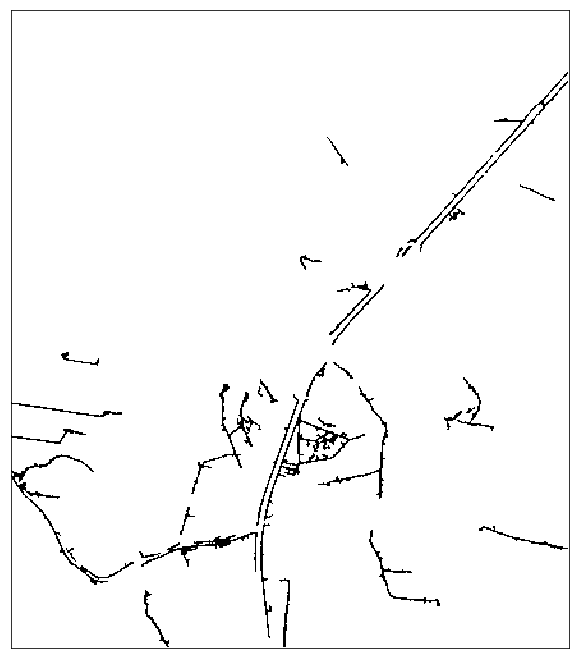

In [72]:
plt.figure(num=None, figsize=(10,10), facecolor='w', edgecolor='k')
ax = [plt.subplot(1,1,i+1) for i in range(1)]
for a in ax:
    a.set_xticklabels([])
    a.set_yticklabels([])
    a.tick_params(bottom=False, left=False)

plt.subplots_adjust(wspace=0.025,hspace=0.05, top=0.99, bottom=0.01)

x,y = (25,190)

ax[0].imshow(islands_removed, cmap='gray')

plt.savefig("publ_post_process_step_6.jpg", format="jpg", dpi=600, bbox_inches="tight")

In [11]:
imp_uppsala = np.load("../../recreated/imp/imp_classified_17.npy")
svf_uppsala = np.load("../../recreated/svf/svf_classified_17.npy")

In [167]:
ditches_3 = np.load("features/Ditches_width3_zone3.npy")[1800:,0:1200]
                    
hpmf_custome = np.load("features/HPMF_custom_filter_zone3.npy")[1800:,0:1200]
hpmf_raw = np.load("features/HPMF_zone3_raw.npy")[1800:,0:1200]

imp_amp = np.load("features/Impoundment_amplification_10_10_10_zone3.npy")[1800:,0:1200]
imp_median4 = np.load("features/Impoundment_median4_zone3.npy")[1800:,0:1200]
imp_raw = np.load("features/Impoundment_zone3_raw.npy")[1800:,0:1200]

skyview_cone = np.load("features/Skyview_cone_5_0975_mean4_opening4_zone3.npy")[1800:,0:1200]
skyview_mean3 = np.load("features/Skyview_mean3_zone3.npy")[1800:,0:1200]
skyview_non_ditch_amp = np.load("features/Skyview_non_ditch_amplification_25_10_zone3.npy")[1800:,0:1200]
skyview_raw = np.load("features/Skyview_zone3_raw.npy")[1800:,0:1200]

slope_non_ditch_amp = np.load("features/Slope_non_ditch_amplification_35_15_zone3.npy")[1800:,0:1200]
slope_raw = np.load("features/Slope_zone3_raw.npy")[1800:,0:1200]

In [3]:
test = pd.read_pickle("../../zones_features_final/zone_17.pickle")

In [4]:
test.columns

Index(['label_3m', 'hpmf_raw', 'skyview_raw', 'impundment_raw', 'slope_raw',
       'DEM_ditch_detection', 'DEM_ditch_detection_no_streams', 'conic_mean',
       'skyview_non_ditch', 'skyview_gabor', 'conic_mean_no_streams',
       'skyview_gabor_no_streams', 'skyview_mean_2', 'skyview_mean_3',
       'skyview_mean_4', 'skyview_mean_6', 'skyview_median_2',
       'skyview_median_4', 'skyview_median_6', 'skyview_min_2',
       'skyview_min_4', 'skyview_min_6', 'skyview_max_2', 'skyview_max_4',
       'skyview_max_6', 'skyview_std_2', 'skyview_std_4', 'skyview_std_6',
       'impundment_amplified', 'impoundment_amplified_no_streams',
       'impundment_mean_2', 'impundment_mean_3', 'impundment_mean_4',
       'impundment_mean_6', 'impundment_median_2', 'impundment_median_4',
       'impundment_median_6', 'impundment_min_2', 'impundment_min_4',
       'impundment_min_6', 'impundment_max_2', 'impundment_max_4',
       'impundment_max_6', 'impundment_std_2', 'impundment_std_4',
       'impu

In [5]:
labels = test["label_3m"].values
imp_mean_3 = test["impundment_mean_3"].values
hpmf_mean_4 = test["hpmf_mean_4"].values
skyview_gabor = test["skyview_gabor"].values
hpmf_gabor = test["hpmf_gabor"].values
imp_ditch_amp = test["impundment_amplified"].values
imp_ditch_amp_no_streams = test["impoundment_amplified_no_streams"].values
slope_std_6 = test["slope_std_6"].values
skyview_non_ditch_amp = test["skyview_non_ditch"].values
hpmf_ditch_amp = test["hpmf_filter"].values
hpmf_ditch_amp_no_streams = test["hpmf_filter_no_streams"].values
skyview_max_6 = test["skyview_max_6"].values
hpmf_mean_4 = test["hpmf_mean_4"].values

In [6]:
skyview_gabor = test["skyview_gabor"].values
hpmf_ditch = test["hpmf_filter"].values

In [7]:
skyview_gabor = skyview_gabor.reshape(2997, 2620)
hpmf_ditch = hpmf_ditch.reshape(2997, 2620)

In [8]:
#label_3m = label_3m.reshape(2997, 2620)

labels = labels.reshape(2997, 2620)
imp_mean_3 = imp_mean_3.reshape(2997, 2620)
hpmf_mean_4 = hpmf_mean_4.reshape(2997, 2620)
skyview_gabor = skyview_gabor.reshape(2997, 2620)
hpmf_gabor = hpmf_gabor.reshape(2997, 2620)
imp_ditch_amp = imp_ditch_amp.reshape(2997, 2620)
imp_ditch_amp_no_streams = imp_ditch_amp_no_streams.reshape(2997, 2620)
slope_std_6 = slope_std_6.reshape(2997, 2620)
skyview_non_ditch_amp = skyview_non_ditch_amp.reshape(2997, 2620)
hpmf_ditch_amp = hpmf_ditch_amp.reshape(2997, 2620)
hpmf_ditch_amp_no_streams = hpmf_ditch_amp_no_streams.reshape(2997, 2620)
skyview_max_6 = skyview_max_6.reshape(2997, 2620)
hpmf_mean_4 = hpmf_mean_4.reshape(2997, 2620)

In [9]:
#label_3m = label_3m[1997:2997, 400:1400]

labels = labels[1997:2997, 400:1400]
imp_mean_3 = imp_mean_3[1997:2997, 400:1400]
hpmf_mean_4 = hpmf_mean_4[1997:2997, 400:1400]
skyview_gabor = skyview_gabor[1997:2997, 400:1400]
hpmf_gabor = hpmf_gabor[1997:2997, 400:1400]
imp_ditch_amp = imp_ditch_amp[1997:2997, 400:1400]
imp_ditch_amp_no_streams = imp_ditch_amp_no_streams[1997:2997, 400:1400]
slope_std_6 = slope_std_6[1997:2997, 400:1400]
skyview_non_ditch_amp = skyview_non_ditch_amp[1997:2997, 400:1400]
hpmf_ditch_amp = hpmf_ditch_amp[1997:2997, 400:1400]
hpmf_ditch_amp_no_streams = hpmf_ditch_amp_no_streams[1997:2997, 400:1400]
skyview_max_6 = skyview_max_6[1997:2997, 400:1400]

'\nax[0].text(x,y,"A", fontsize=50, fontdict={"color":"white"}, path_effects=[path_effects.withStroke(linewidth=4, foreground=\'black\')])\nax[0].imshow(labels * -1, cmap=\'gray\')\n\nax[1].text(x,y,"B", fontsize=50, fontdict={"color":"white"}, path_effects=[path_effects.withStroke(linewidth=4, foreground=\'black\')])\nax[1].imshow(slope_std_6 * -1, cmap=\'gray\')\n\nax[2].text(x,y,"C", fontsize=50, fontdict={"color":"white"}, path_effects=[path_effects.withStroke(linewidth=4, foreground=\'black\')])\nax[2].imshow(hpmf_mean_4, cmap=\'gray\')\n\nax[3].text(x,y,"D", fontsize=50, fontdict={"color":"white"}, path_effects=[path_effects.withStroke(linewidth=4, foreground=\'black\')])\nax[3].imshow(hpmf_gabor, cmap=\'gray\')\n\nax[4].text(x,y,"E", fontsize=50, fontdict={"color":"white"}, path_effects=[path_effects.withStroke(linewidth=4, foreground=\'black\')])\nax[4].imshow(hpmf_ditch_amp * -1, cmap=\'gray\')\n\nax[5].text(x,y,"F", fontsize=50, fontdict={"color":"white"}, path_effects=[path_

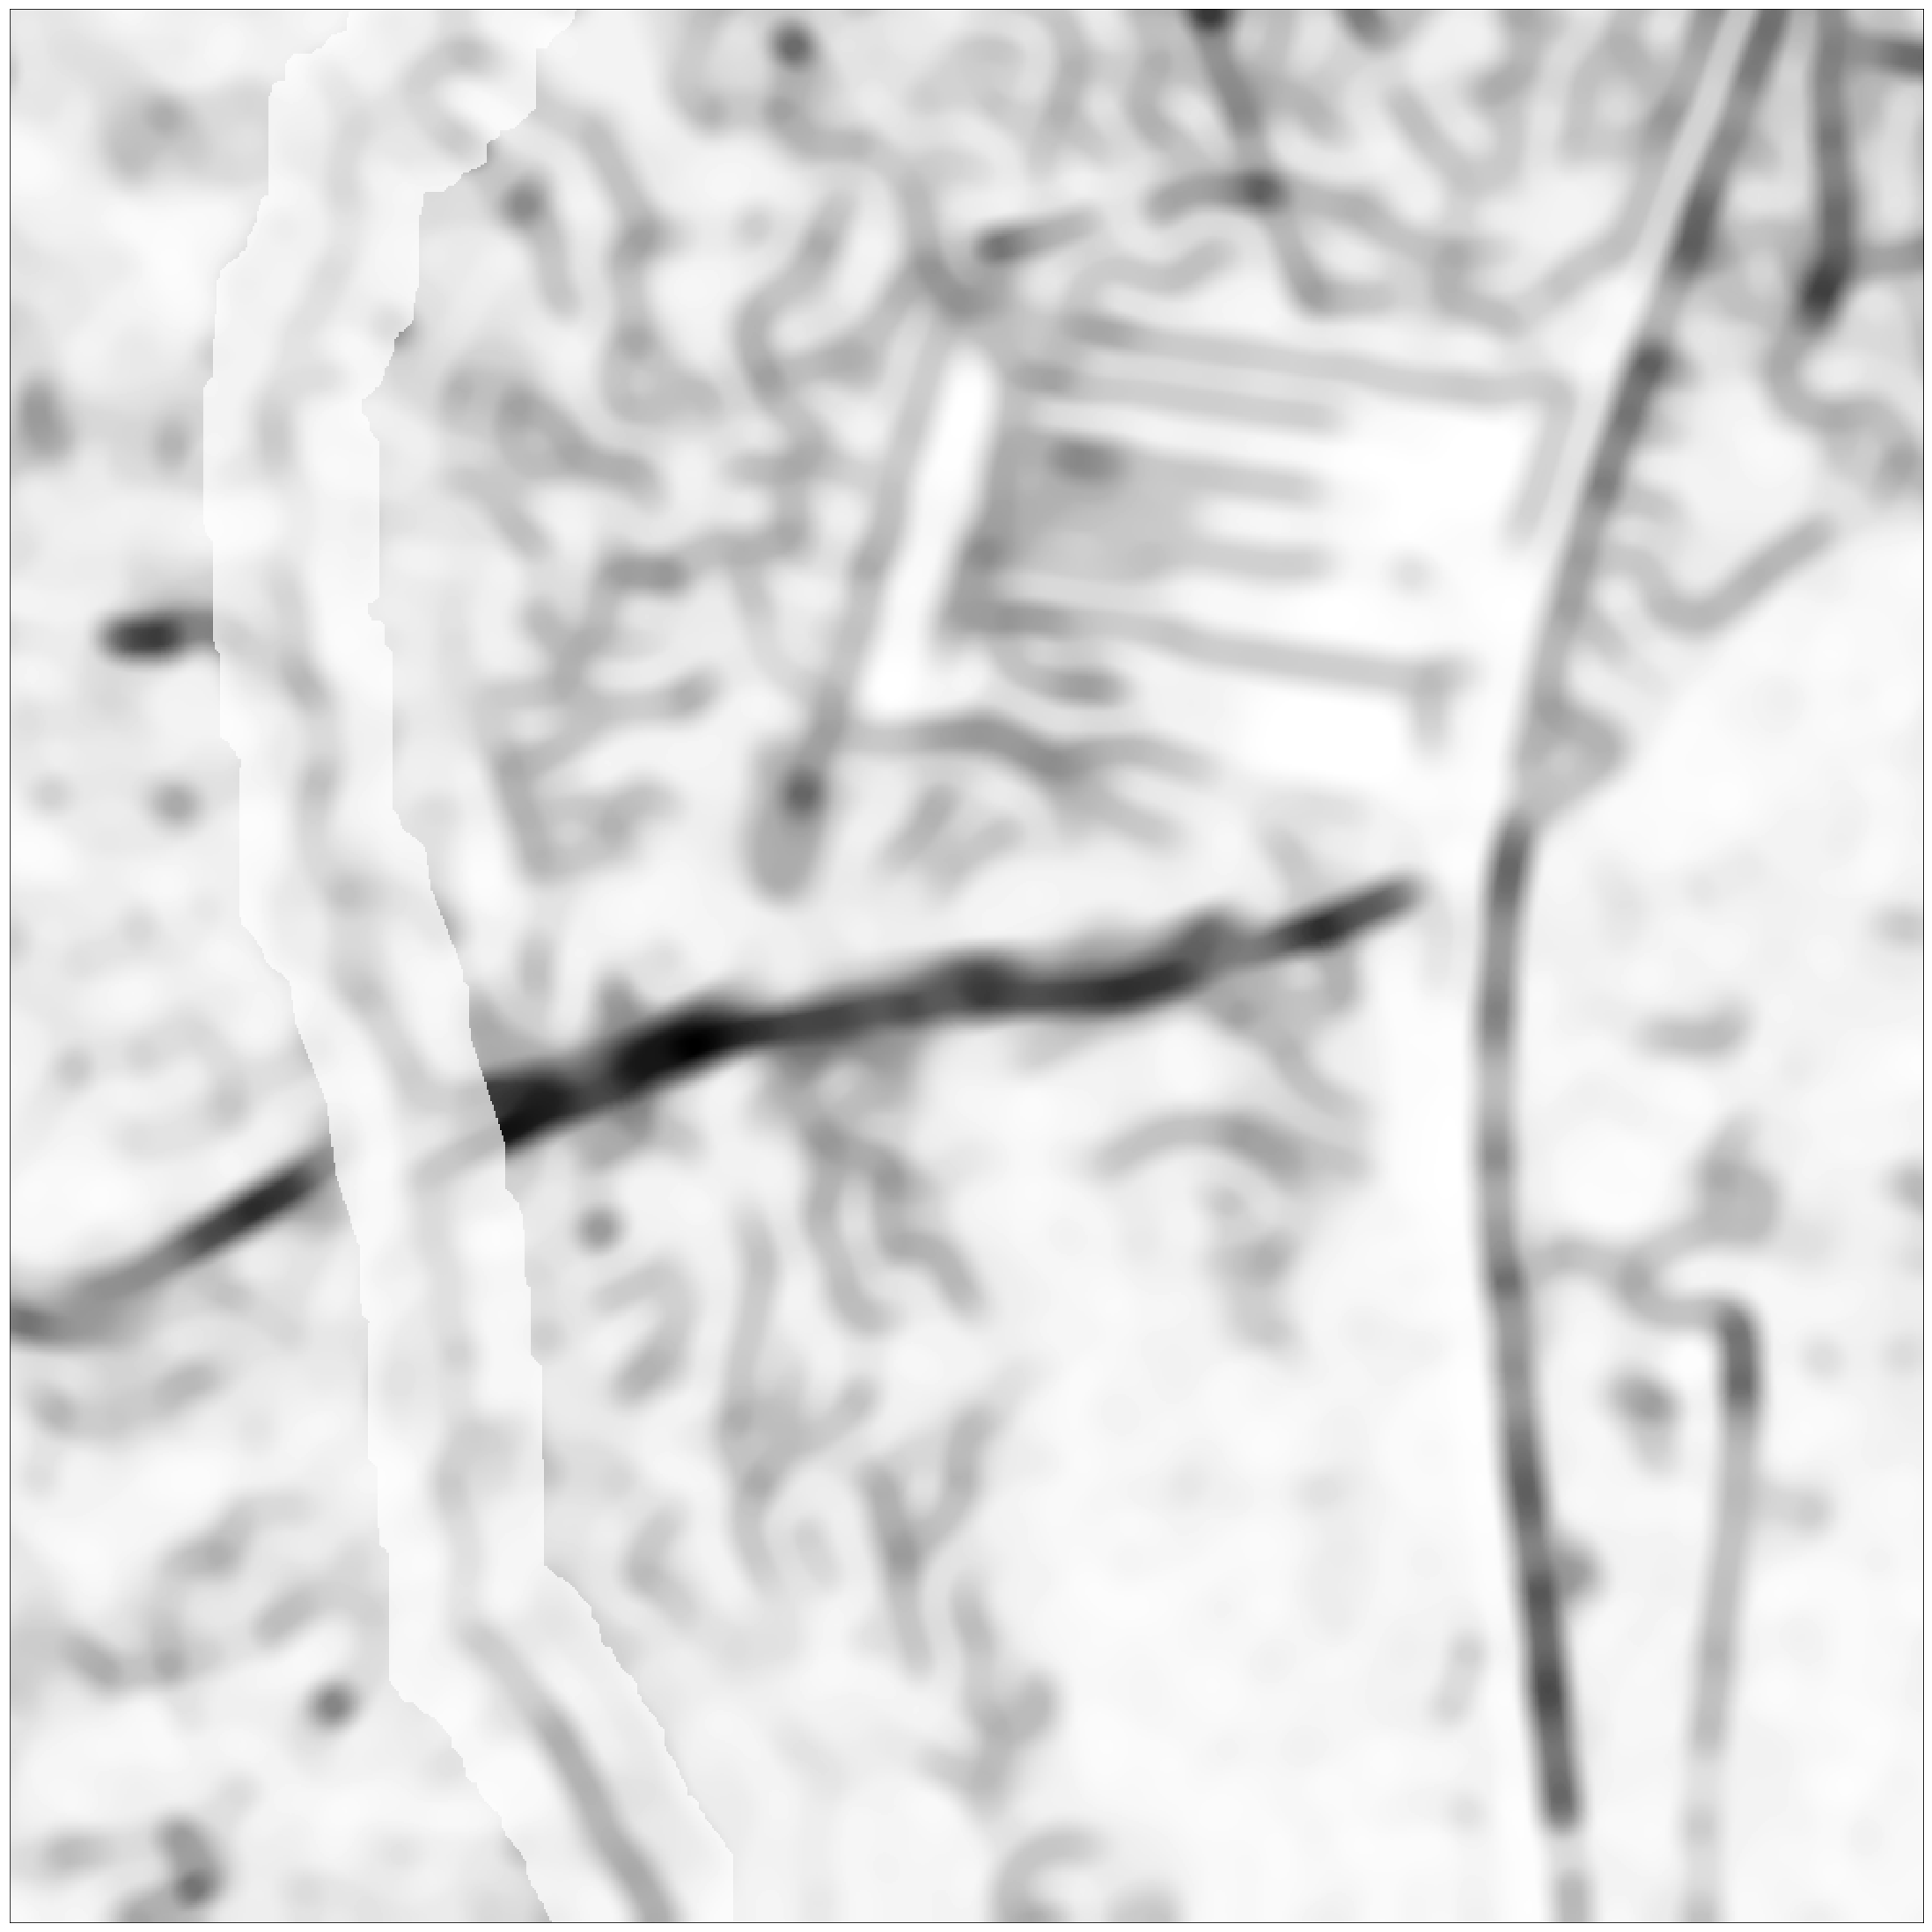

In [15]:
plt.figure(num=None, figsize=(40,40), facecolor='w', edgecolor='k')
#ax = [plt.subplot(4,3,i+1) for i in range(12)]
#for a in ax:
#    a.set_xticklabels([])
#    a.set_yticklabels([])
#    a.tick_params(bottom=False, left=False)

#plt.subplots_adjust(wspace=0.025,hspace=0.05, top=0.99, bottom=0.01)

#x,y = (25,80)

plt.xticks([],[])
plt.yticks([],[])
plt.imshow(labels * -1, cmap='gray')
plt.savefig("feature_a.jpg", format="jpg", bbox_inches="tight")

plt.imshow(slope_std_6 * -1, cmap='gray')
plt.savefig("feature_b.jpg", format="jpg", bbox_inches="tight")

plt.imshow(hpmf_mean_4, cmap='gray')
plt.savefig("feature_c.jpg", format="jpg", bbox_inches="tight")

plt.imshow(hpmf_gabor, cmap='gray')
plt.savefig("feature_d.jpg", format="jpg", bbox_inches="tight")

plt.imshow(hpmf_ditch_amp * -1, cmap='gray')
plt.savefig("feature_e.jpg", format="jpg", bbox_inches="tight")

plt.imshow(hpmf_ditch_amp_no_streams * -1, cmap='gray')
plt.savefig("feature_f.jpg", format="jpg", bbox_inches="tight")

plt.imshow(skyview_gabor, cmap='gray')
plt.savefig("feature_g.jpg", format="jpg", bbox_inches="tight")

plt.imshow(skyview_max_6, cmap='gray')
plt.savefig("feature_h.jpg", format="jpg", bbox_inches="tight")

plt.imshow(skyview_non_ditch_amp  * -1, cmap='gray')
plt.savefig("feature_i.jpg", format="jpg", bbox_inches="tight")

plt.imshow(imp_mean_3 * -1, cmap='gray')
plt.savefig("feature_j.jpg", format="jpg", bbox_inches="tight")

plt.imshow(imp_ditch_amp * -1, cmap='gray')
plt.savefig("feature_k.jpg", format="jpg", bbox_inches="tight")

plt.imshow(imp_ditch_amp_no_streams * -1, cmap='gray')
plt.savefig("feature_l.jpg", format="jpg", bbox_inches="tight")


'''
ax[0].text(x,y,"A", fontsize=50, fontdict={"color":"white"}, path_effects=[path_effects.withStroke(linewidth=4, foreground='black')])
ax[0].imshow(labels * -1, cmap='gray')

ax[1].text(x,y,"B", fontsize=50, fontdict={"color":"white"}, path_effects=[path_effects.withStroke(linewidth=4, foreground='black')])
ax[1].imshow(slope_std_6 * -1, cmap='gray')

ax[2].text(x,y,"C", fontsize=50, fontdict={"color":"white"}, path_effects=[path_effects.withStroke(linewidth=4, foreground='black')])
ax[2].imshow(hpmf_mean_4, cmap='gray')

ax[3].text(x,y,"D", fontsize=50, fontdict={"color":"white"}, path_effects=[path_effects.withStroke(linewidth=4, foreground='black')])
ax[3].imshow(hpmf_gabor, cmap='gray')

ax[4].text(x,y,"E", fontsize=50, fontdict={"color":"white"}, path_effects=[path_effects.withStroke(linewidth=4, foreground='black')])
ax[4].imshow(hpmf_ditch_amp * -1, cmap='gray')

ax[5].text(x,y,"F", fontsize=50, fontdict={"color":"white"}, path_effects=[path_effects.withStroke(linewidth=4, foreground='black')])
ax[5].imshow(hpmf_ditch_amp_no_streams * -1, cmap='gray')

ax[6].text(x,y,"G", fontsize=50, fontdict={"color":"white"}, path_effects=[path_effects.withStroke(linewidth=4, foreground='black')])
ax[6].imshow(skyview_gabor, cmap='gray')

ax[7].text(x,y,"H", fontsize=50, fontdict={"color":"white"}, path_effects=[path_effects.withStroke(linewidth=4, foreground='black')])
ax[7].imshow(skyview_max_6, cmap='gray')

ax[8].text(x,y,"I", fontsize=50, fontdict={"color":"white"}, path_effects=[path_effects.withStroke(linewidth=4, foreground='black')])
ax[8].imshow(skyview_non_ditch_amp  * -1, cmap='gray')

ax[9].text(x,y,"J", fontsize=50, fontdict={"color":"white"}, path_effects=[path_effects.withStroke(linewidth=4, foreground='black')])
ax[9].imshow(imp_mean_3 * -1, cmap='gray')

ax[10].text(x,y,"K", fontsize=50, fontdict={"color":"white"}, path_effects=[path_effects.withStroke(linewidth=4, foreground='black')])
ax[10].imshow(imp_ditch_amp * -1, cmap='gray')

ax[11].text(x,y,"L", fontsize=50, fontdict={"color":"white"}, path_effects=[path_effects.withStroke(linewidth=4, foreground='black')])
ax[11].imshow(imp_ditch_amp_no_streams * -1, cmap='gray')

plt.savefig("publ_features.jpg", format="jpg", dpi=600, bbox_inches="tight")'''

In [80]:
slope_xjobb = slope_std_6 = test["slope_raw"].values
slope_xjobb = slope_xjobb.reshape(2997, 2620)

In [2]:
prediction = np.load("../../Slutexperiment/predictions.npy")

In [9]:
def raster_to_zones(arr, zoneSize, threshold):
    """
    Converts binary pixel labels to zones with a specified zone size and threshold.
    """
    new_arr = arr.copy()
    for i in range(0, len(arr), zoneSize):
        for j in range(0, len(arr[i]), zoneSize):
            numberOfClassified = 0
            if i < len(arr) - zoneSize and j < len(arr[i]) - zoneSize:
                for k in range(zoneSize):
                    for l in range(zoneSize):
                        if arr[i + k][j + l] == 1:
                            numberOfClassified += 1
                if numberOfClassified > (zoneSize**2)/threshold:
                    for k in range(zoneSize):
                        for l in range(zoneSize):
                            new_arr[i + k][j + l] = 1
                else:
                    for k in range(zoneSize):
                        for l in range(zoneSize):
                            new_arr[i + k][j + l] = 0
    return new_arr

In [11]:
for k, zone_pred in enumerate(prediction):
    validation = raster_to_zones(zone_pred[2].reshape(2997,2620), 6, 4)
    amount = np.sum(validation == 1)
    print(f"Zone {k + 1}: {amount}")

Zone 1: 156005
Zone 2: 377797
Zone 3: 186354
Zone 4: 208994
Zone 5: 251435
Zone 6: 98385
Zone 7: 133720
Zone 8: 78254
Zone 9: 73762
Zone 10: 70492
Zone 11: 101453


In [86]:
z4 = prediction[4][0]

In [88]:
z4 = z4.reshape(2997, 2620)

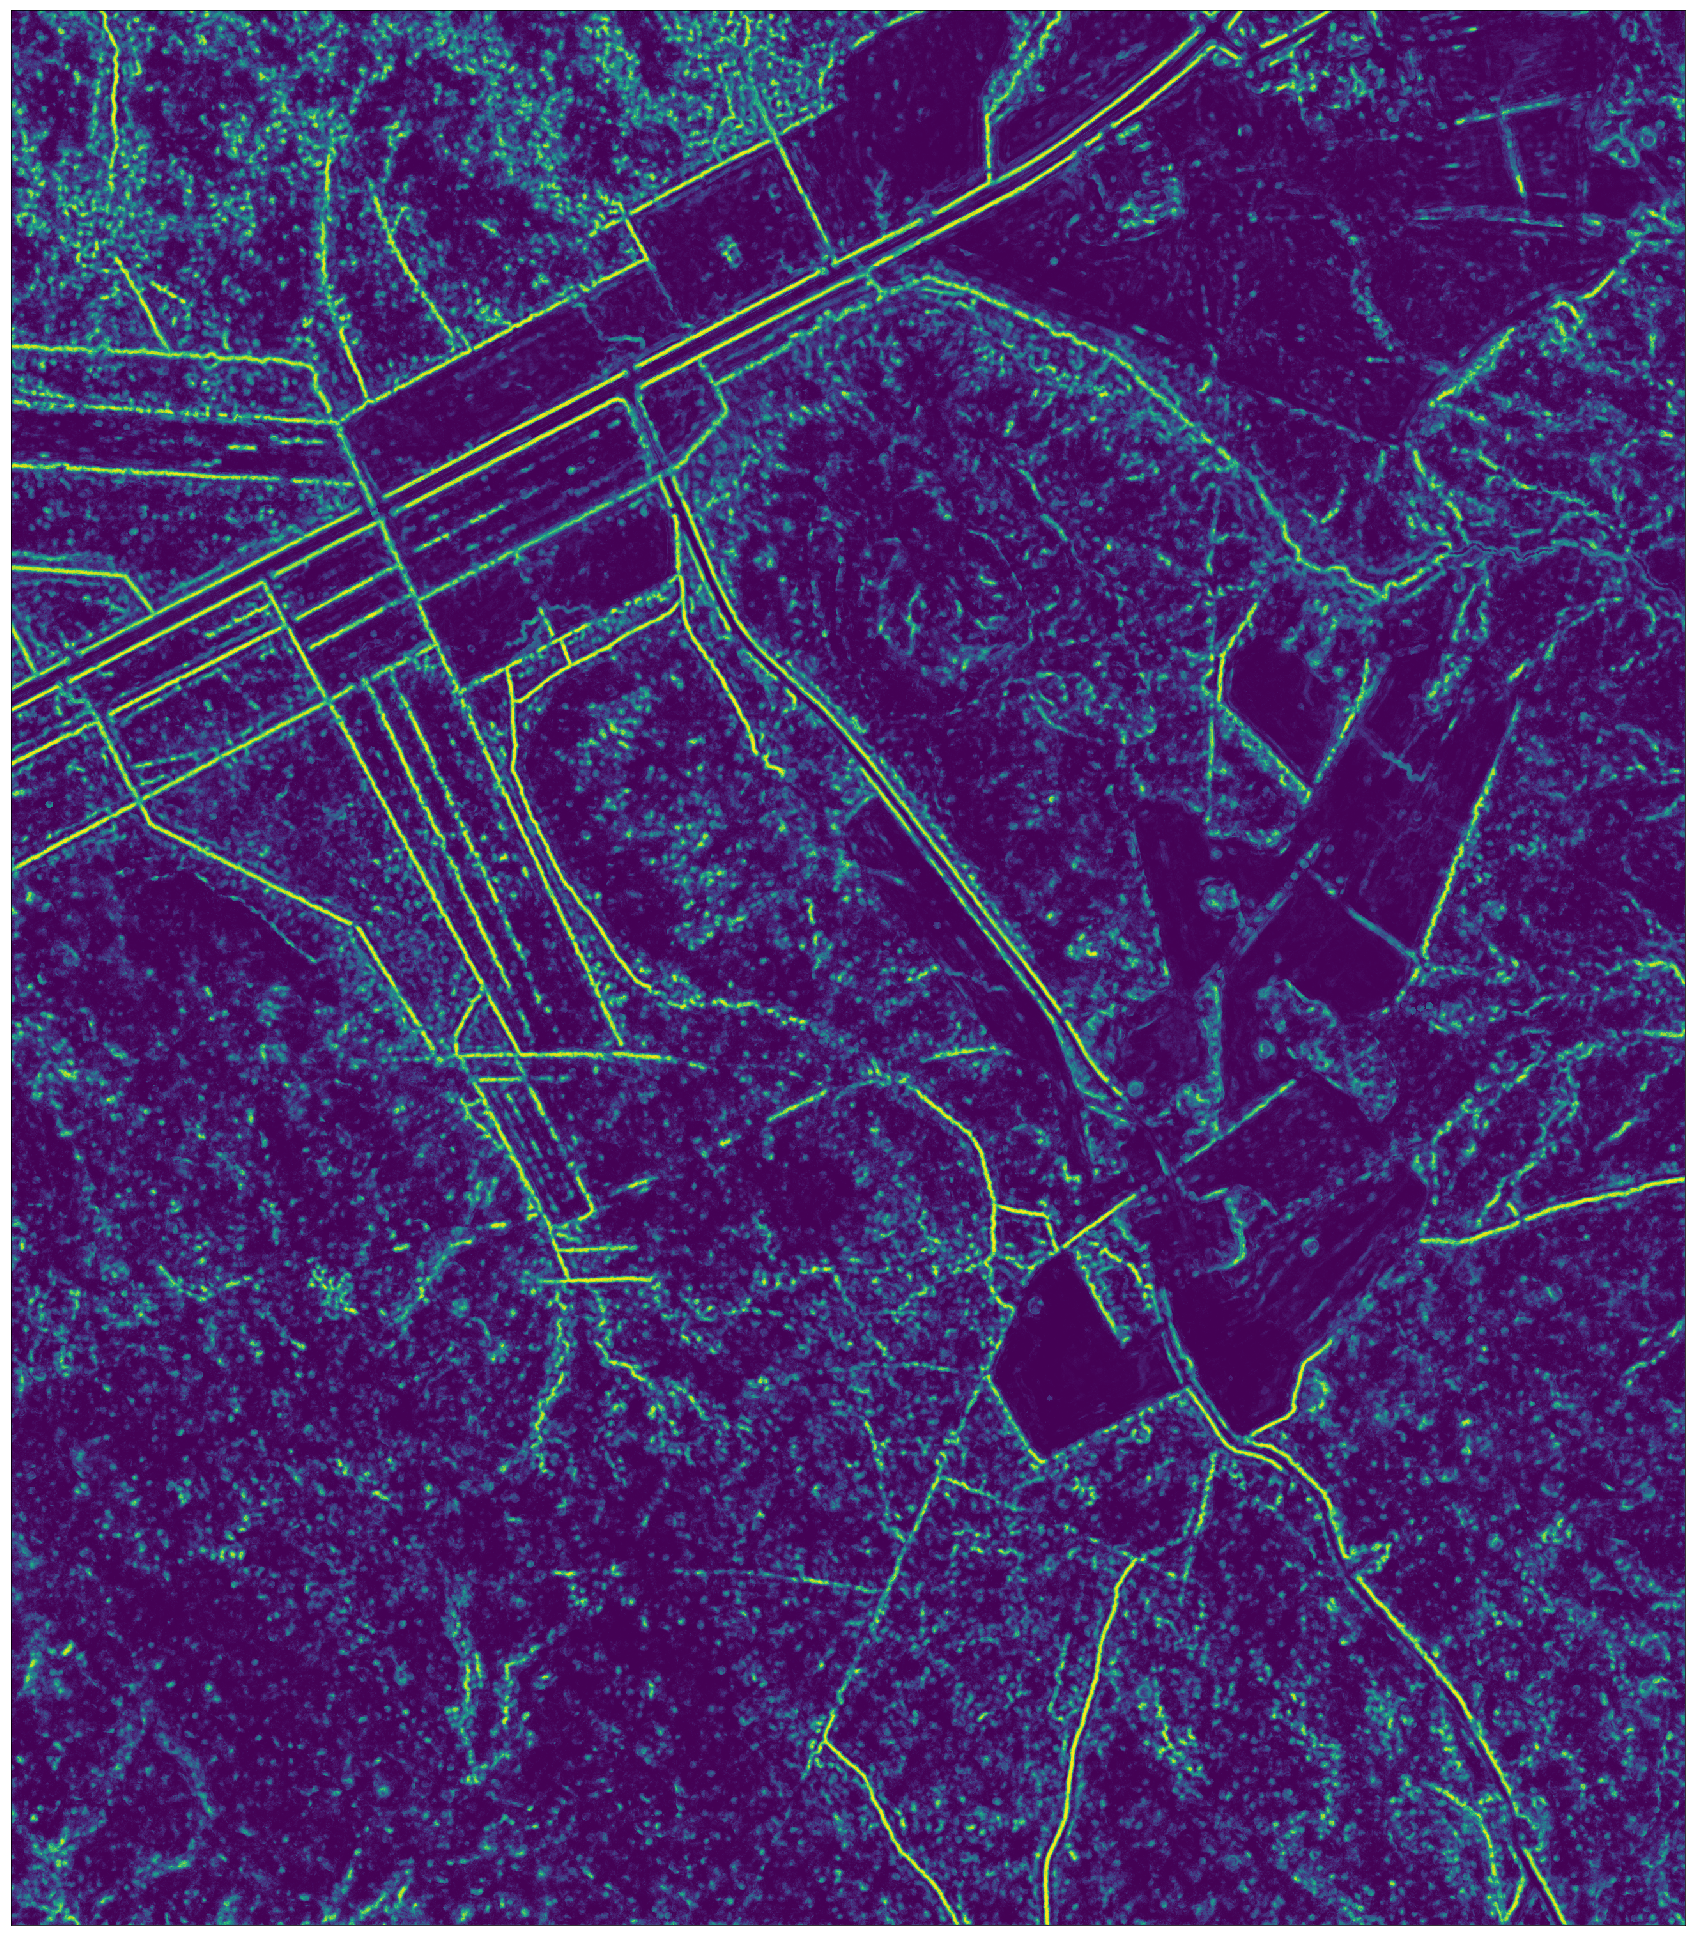

In [90]:
import matplotlib.patheffects as path_effects

plt.figure(num=None, figsize=(30,32), facecolor='w', edgecolor='k')
ax = [plt.subplot(1,1,i+1) for i in range(1)]
for a in ax:
    a.set_xticklabels([])
    a.set_yticklabels([])
    a.tick_params(bottom=False, left=False)
plt.subplots_adjust(wspace=0.025,hspace=0.05, top=0.99, bottom=0.01)


ax[0].imshow(z4)

plt.savefig("pred_xjobb.pdf", format="pdf", dpi=50)

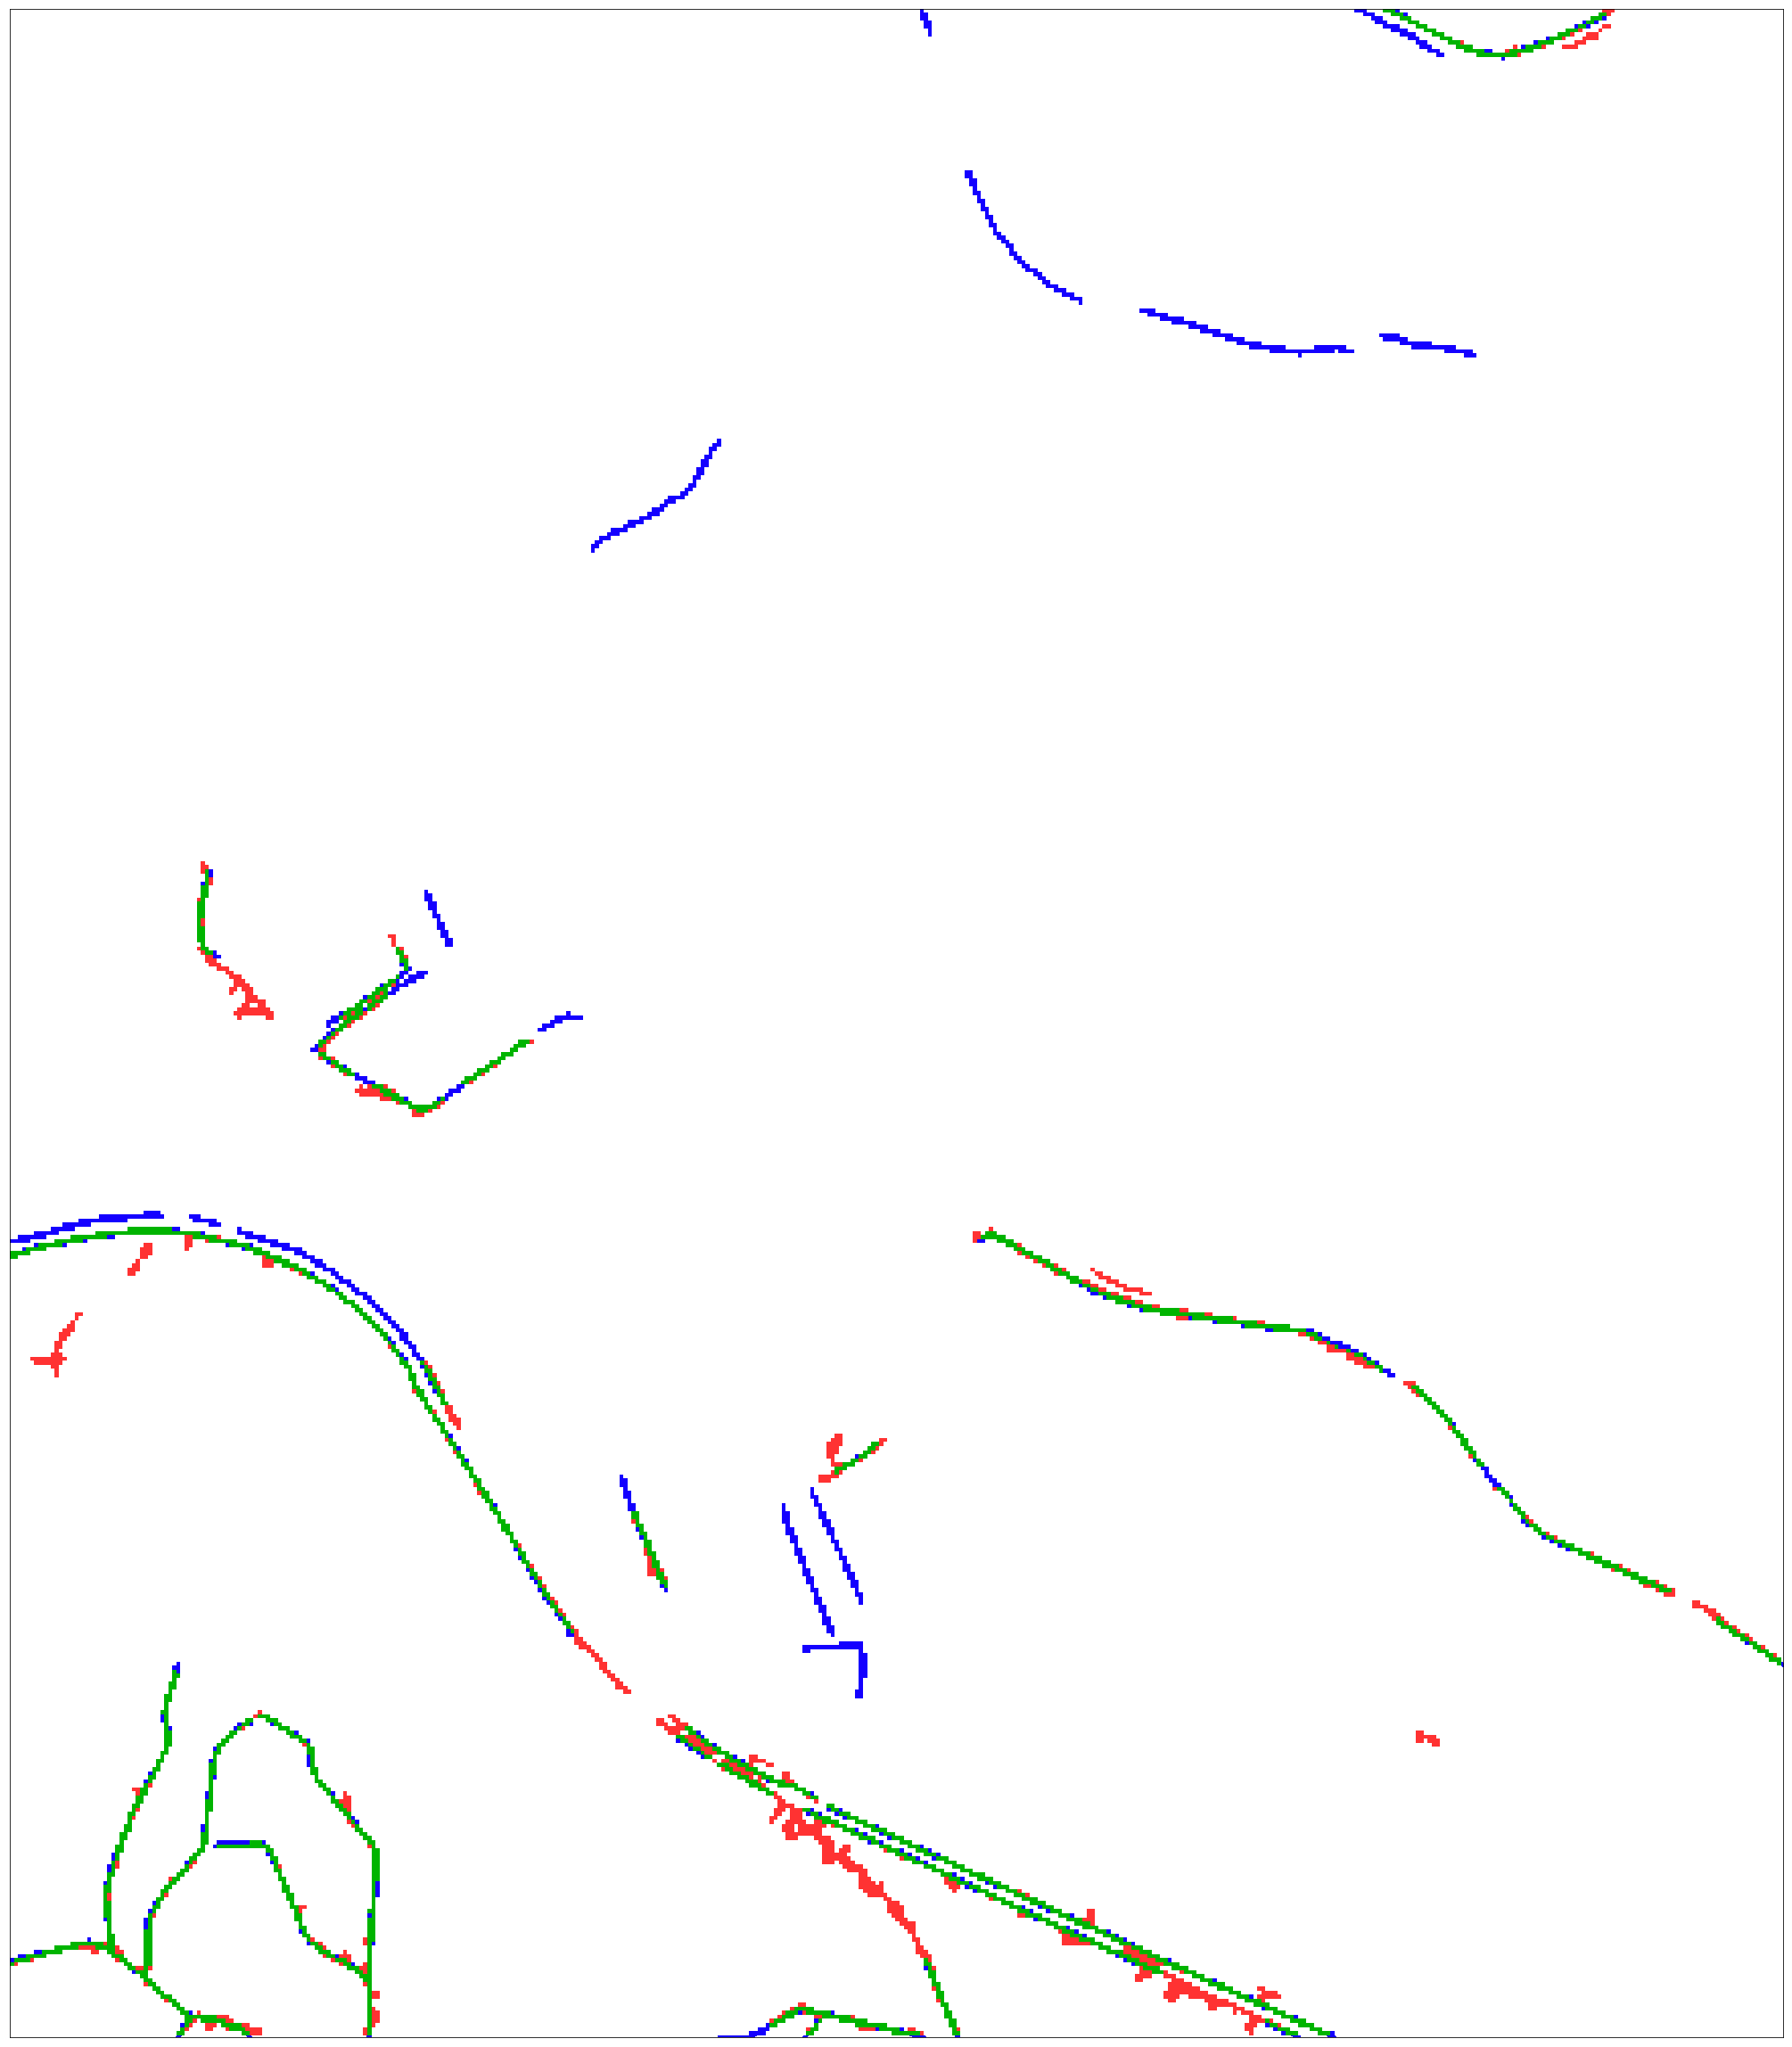

In [11]:
from PIL import Image
plt.figure(num=None, figsize=(30,32), facecolor='w', edgecolor='w')
ax = [plt.subplot(1,1,i+1) for i in range(1)]
for a in ax:
    a.set_xticklabels([])
    a.set_yticklabels([])
    a.tick_params(bottom=False, left=False)
plt.subplots_adjust(wspace=0,hspace=0.1)

for k, zone_pred in enumerate(predictions):
    validation = zone_pred[2].reshape(2997,2620)
    pred = zone_pred[1].reshape(2997,2620)
    displayImg = Image.new("RGB", (2620, 2997), "white")
    pixels = displayImg.load()
    for i in range(displayImg.size[0]):
        for j in range(displayImg.size[1]):
            if validation[j][i] == 1 and pred[j][i] == 1:
                pixels[i,j] = (0, 180, 0)
            elif validation[j][i] == 1 and pred[j][i] == 0:
                pixels[i,j] = (20, 0, 255)
            elif validation[j][i] == 0 and pred[j][i] == 1:
                pixels[i,j] = (255, 50, 50)
    ax[0].imshow(displayImg)

    plt.tight_layout()
    plt.savefig(f"zone_result_{k+1}.pdf", format="pdf", dpi=50)

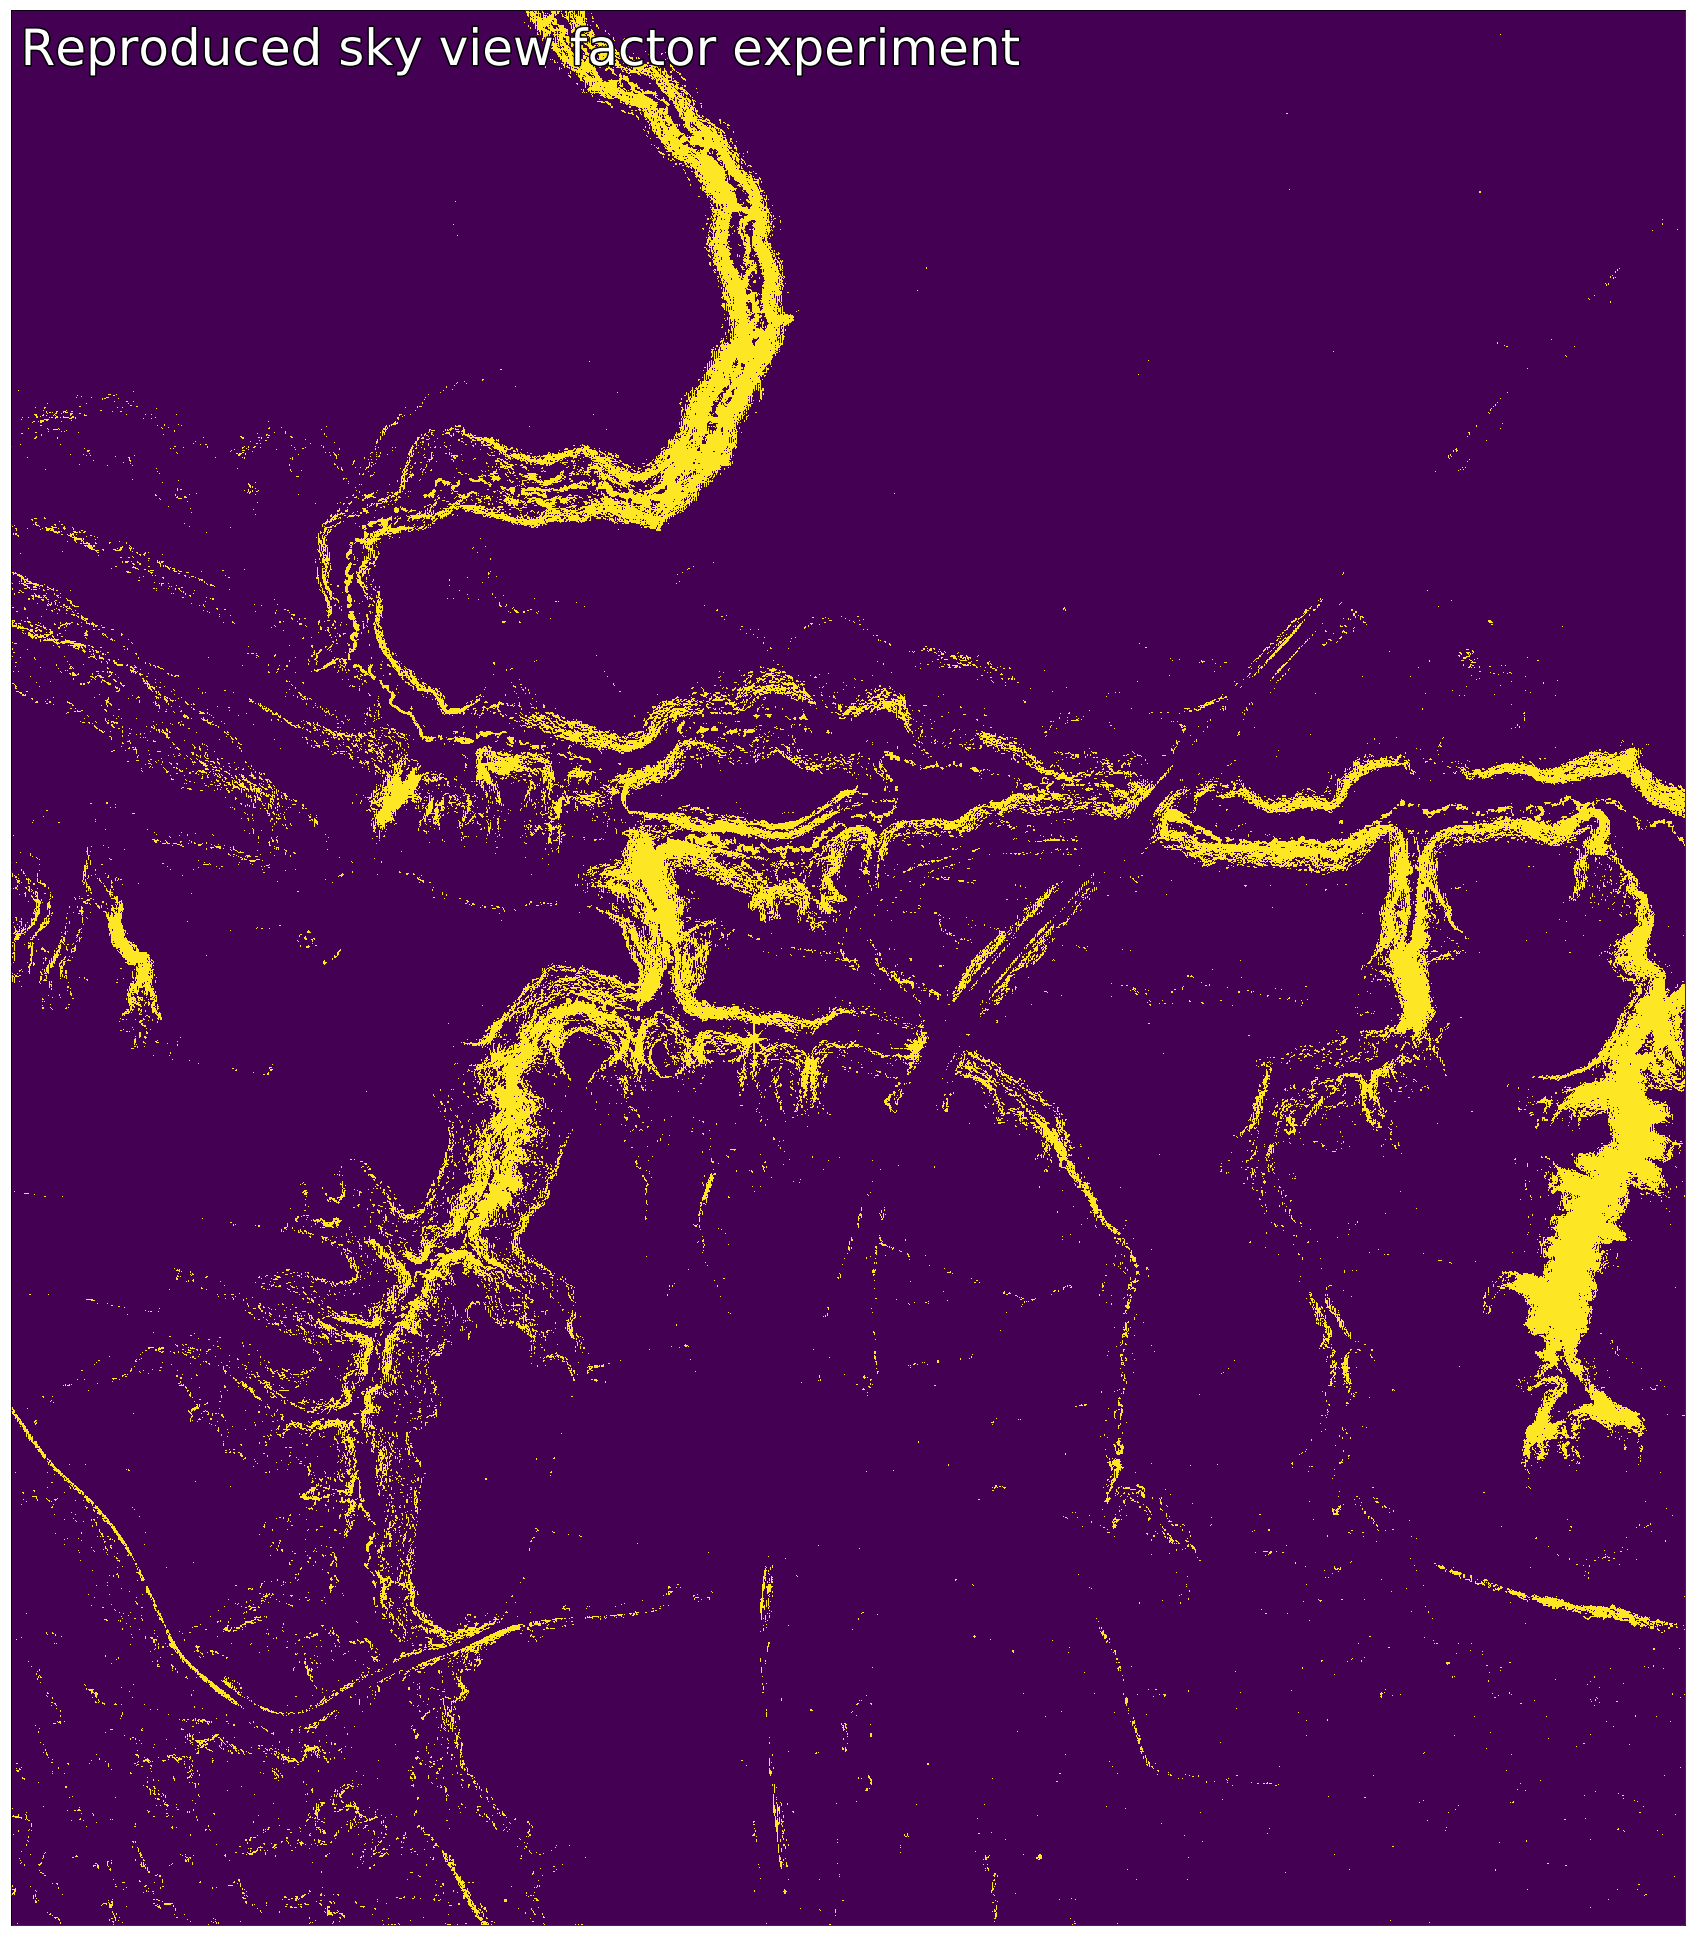

In [13]:
import matplotlib.patheffects as path_effects

plt.figure(num=None, figsize=(30,32), facecolor='w', edgecolor='k')
ax = [plt.subplot(1,1,i+1) for i in range(1)]
for a in ax:
    a.set_xticklabels([])
    a.set_yticklabels([])
    a.tick_params(bottom=False, left=False)
plt.subplots_adjust(wspace=0.025,hspace=0.05, top=0.99, bottom=0.01)

x,y = (15,85)


ax[0].text(x,y,"Reproduced sky view factor experiment", fontsize=50, fontdict={"color":"white"}, path_effects=[path_effects.withStroke(linewidth=3, foreground='black')])
ax[0].imshow(svf_uppsala)


""""
ax[0].text(x,y,"A", fontsize=40, fontdict={"color":"white"}, path_effects=[path_effects.withStroke(linewidth=3, foreground='black')])
ax[0].imshow(labels)

ax[1].text(x,y,"B", fontsize=40, fontdict={"color":"white"}, path_effects=[path_effects.withStroke(linewidth=3, foreground='black')])
ax[1].imshow(slope_std_6)

ax[2].text(x,y,"C", fontsize=40, fontdict={"color":"white"}, path_effects=[path_effects.withStroke(linewidth=3, foreground='black')])
ax[2].imshow(hpmf_mean_4)

# ----------------------------------------------------------

ax[3].text(x,y,"D", fontsize=40, fontdict={"color":"white"}, path_effects=[path_effects.withStroke(linewidth=3, foreground='black')])
ax[3].imshow(hpmf_gabor)

ax[4].text(x,y,"E", fontsize=40, fontdict={"color":"white"}, path_effects=[path_effects.withStroke(linewidth=3, foreground='black')])
ax[4].imshow(hpmf_ditch_amp)

ax[5].text(x,y,"F", fontsize=40, fontdict={"color":"white"}, path_effects=[path_effects.withStroke(linewidth=3, foreground='black')])
ax[5].imshow(hpmf_ditch_amp_no_streams)

# ----------------------------------------------------------

ax[6].text(x,y,"G", fontsize=40, fontdict={"color":"white"}, path_effects=[path_effects.withStroke(linewidth=3, foreground='black')])
ax[6].imshow(skyview_gabor)

ax[7].text(x,y,"H", fontsize=40, fontdict={"color":"white"}, path_effects=[path_effects.withStroke(linewidth=3, foreground='black')])
ax[7].imshow(skyview_max_6)

ax[8].text(x,y,"I", fontsize=40, fontdict={"color":"white"}, path_effects=[path_effects.withStroke(linewidth=3, foreground='black')])
ax[8].imshow(skyview_non_ditch_amp)

# ----------------------------------------------------------

ax[9].text(x,y,"J", fontsize=40, fontdict={"color":"white"}, path_effects=[path_effects.withStroke(linewidth=3, foreground='black')])
ax[9].imshow(imp_mean_3)

ax[10].text(x,y,"K", fontsize=40, fontdict={"color":"white"}, path_effects=[path_effects.withStroke(linewidth=3, foreground='black')])
ax[10].imshow(imp_ditch_amp)

ax[11].text(x,y,"L", fontsize=40, fontdict={"color":"white"}, path_effects=[path_effects.withStroke(linewidth=3, foreground='black')])
ax[11].imshow(imp_ditch_amp_no_streams)
"""

plt.savefig("reproduced_svf_17.pdf", format="pdf", dpi=50)

In [40]:
import sys
sys.path.append("..") 
from helper import index as helpers

In [43]:
def raster_to_zones(arr, zoneSize, threshold):
    """
    Converts binary pixel labels to zones with a specified zone size and threshold.
    """
    new_arr = arr.copy()
    for i in range(0, len(arr), zoneSize):
        for j in range(0, len(arr[i]), zoneSize):
            numberOfClassified = 0
            if i < len(arr) - zoneSize and j < len(arr[i]) - zoneSize:
                for k in range(zoneSize):
                    for l in range(zoneSize):
                        if arr[i + k][j + l] == 1:
                            numberOfClassified += 1
                if numberOfClassified > (zoneSize**2)/threshold:
                    for k in range(zoneSize):
                        for l in range(zoneSize):
                            new_arr[i + k][j + l] = 1
                else:
                    for k in range(zoneSize):
                        for l in range(zoneSize):
                            new_arr[i + k][j + l] = 0
    return new_arr

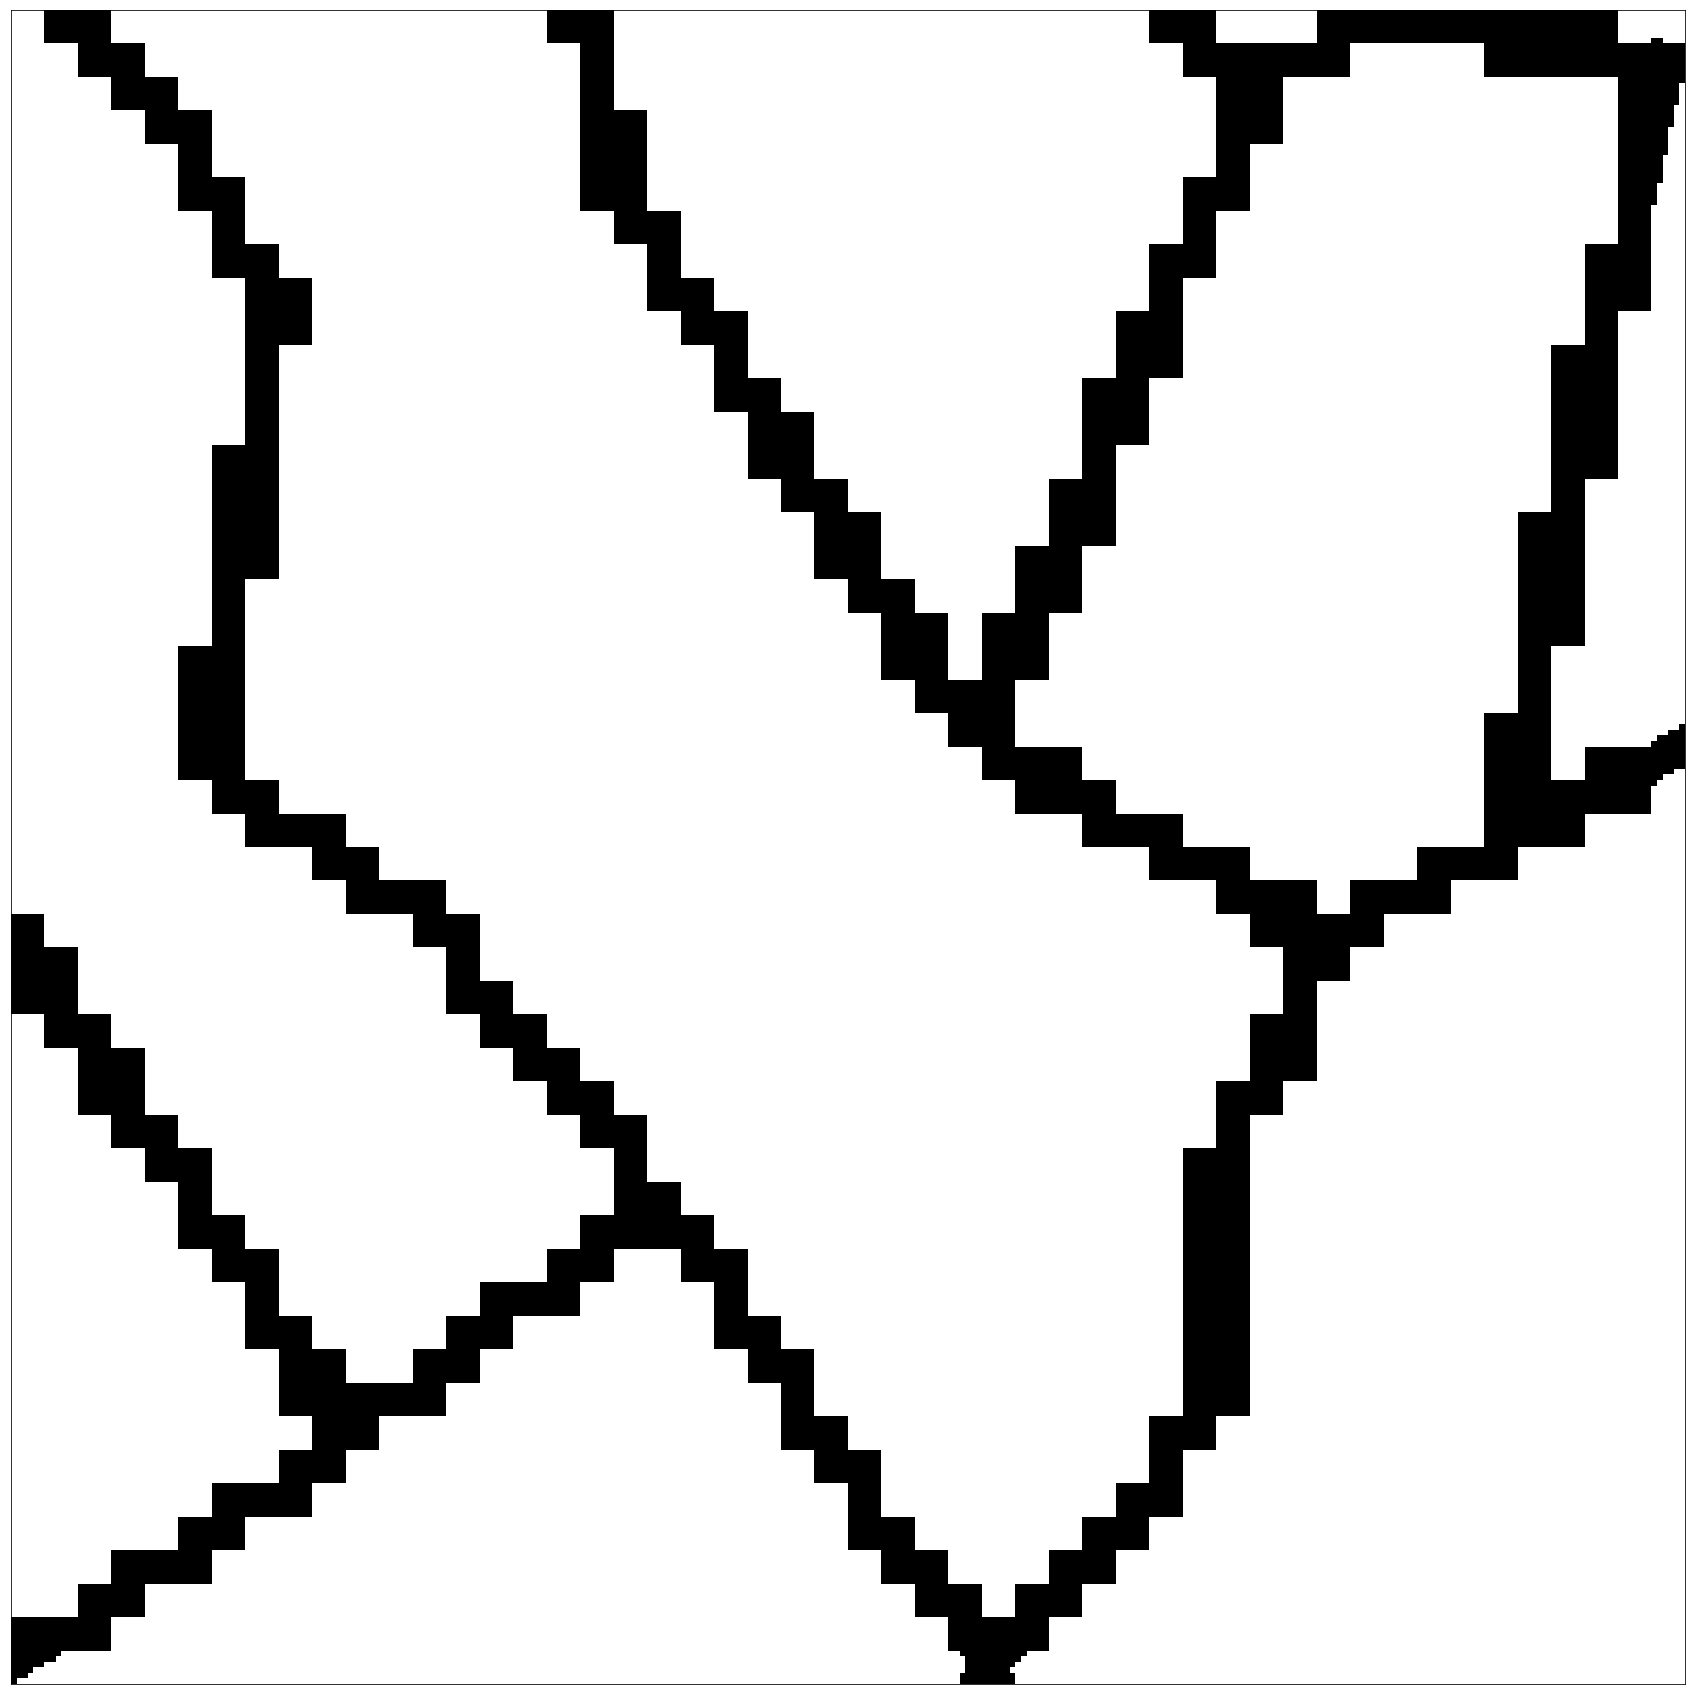

In [79]:
ditches_3 = np.load("../../Raw_Data_21_zones/Labels3m_10.npy")[2300:2600,300:600]
ditches = np.load("../../Raw_Data_21_zones/Ditches_10.npy")[2300:2600,300:600]

x,y = (2,26)

plt.figure(num=None, figsize=(30,32), facecolor='w', edgecolor='k')
ax = [plt.subplot(1,1,i+1) for i in range(1)]
for a in ax:
    a.set_xticklabels([])
    a.set_yticklabels([])
    a.tick_params(bottom=False, left=False)
plt.subplots_adjust(wspace=0.025,hspace=0.05, top=0.99, bottom=0.01)

#ax[0].text(x,y,"A", fontsize=40, fontdict={"color":"white"}, path_effects=[path_effects.withStroke(linewidth=3, foreground='black')])
#ax[0].imshow(ditches * -1, cmap="gray")

#ax[1].text(x,y,"B", fontsize=40, fontdict={"color":"white"}, path_effects=[path_effects.withStroke(linewidth=3, foreground='black')])
#ax[0].imshow(ditches_3 * -1, cmap="gray")

#ax[2].text(x,y,"C", fontsize=40, fontdict={"color":"white"}, path_effects=[path_effects.withStroke(linewidth=3, foreground='black')])
ax[0].imshow(raster_to_zones(ditches_3, 6, 4) * -1, cmap="gray")

plt.savefig("publ_ditch_preprocess_C.jpg", format="jpg", dpi=600, bbox_inches="tight")